## Data Trasformation

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
plt.style.use('seaborn-white')

In [2]:
# Leggiamo il dataframe dal file csv 'acquisti.csv'
acquisti = pd.read_csv('acquisti.csv', sep=',')
acquisti.drop(columns=['Unnamed: 0'], inplace=True)
acquisti.head(3)

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta,Spending
0,536365,2010-12-01 08:26:00,2.55,17850,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,15.30
1,536365,2010-12-01 08:26:00,3.39,17850,United Kingdom,71053,WHITE METAL LANTERN,6,20.34
2,536365,2010-12-01 08:26:00,2.75,17850,United Kingdom,84406B,CREAM CUPID HEARTS COAT HANGER,8,22.00


In [3]:
# I valori della colonna BasketDate sono in formato stringa, per comodità le trasformiamo in formato datetime
acquisti['BasketDate'] = pd.to_datetime(acquisti['BasketDate'], format="%Y-%m-%d %H:%M:%S")

## Attributi

Per ogni cliente mi calcolo i seguenti attributi:
* *I*: è il numero totale di oggetti acquistati dal cliente durante l'intero periodo di osservazione.
* *Iu*: è il numero di oggetti distinti acquisti dal cliente durante l'intero periodo di osservazione.
* *Imax*: è il massimo numero di oggetti acquistati da un cliente in un carrello (shopping session = carello).

### Attributi I e Iu

In [4]:
# Raggruppiamo per CustomerID, quindi sommiamo i valori della colonna Qta e contiamo quanti valori diversi
# della colonna ProdID ci sono
df_I_Iu = acquisti.groupby('CustomerID').aggregate({'Qta':'sum', 'ProdID':'nunique'})
# Rinominiamo le colonne: Qta -> I e ProdID -> Iu
df_I_Iu.rename(columns={'Qta':'I', 'ProdID':'Iu'}, inplace=True)

### Attributo Imax

In [5]:
# Raggruppiamo per CustomerID e BasketID, quindi sommiamo i valori della colonna Qta
df_sum = acquisti.groupby(['CustomerID', 'BasketID']).aggregate({'Qta':'sum'}).reset_index(level='CustomerID')
# Raggruppiamo per CustomerID e ci calcoliamo il valore massimo della colonna Qta
df_Imax = df_sum.groupby('CustomerID').aggregate({'Qta':'max'})
# Rinominiamo la colonna Qta -> Imax
df_Imax.rename(columns={'Qta':'Imax'}, inplace=True)

### Creazione del dataframe clienti

Partendo dai tre dataframe calcolati sopra, creaiamo il dataframe dove ogni riga rappresenta un cliente.

In [6]:
clienti = pd.merge(df_I_Iu, df_Imax, on='CustomerID')

In [7]:
clienti.head(3)

,I,Iu,Imax
CustomerID,,,
12347,2458,103,676
12348,2332,21,1248
12349,630,72,630


### Attributi aggiuntivi

Per ogni cliente calcoliamo i seguenti attributi aggiuntivi:
- **NumBasket**: Il numero totale di carelli che il cliente ha fatto durante il periodo di osservazione. 
- **Recency**: la recency indica il numero di giorni che il cliente è stato inattivo, con riferimento alla data più recente contenuta nel dataset.
- **Frequency**: il numero tatale di ordini fatti dal cliente, durante l'intero periodo di osservazione.
- **MonetaryValue**: quanto  il cliente ha speso in totale, durante l'intero periodo di osservazione.

### Attributo NumBasket

In [8]:
# Raggruppiamo per CustomerID, quindi contiamo quanti valori di BasketID diversi ci sono
df_numBasket = acquisti.groupby('CustomerID').aggregate({'BasketID':'nunique'})
# Rinominiamo la colonna BasketID -> NumBasket
df_numBasket.rename(columns={'BasketID':'NumBasket'}, inplace=True)
# Creiamo nel dataframe clienti una nuova colonna 'NumBasket' e ci assegniamo i valori della rispettiva colonna 
# del dataframe df_numBasket
clienti['NumBasket'] = df_numBasket['NumBasket']

In [9]:
clienti.head(3)

,I,Iu,Imax,NumBasket
CustomerID,,,,
12347,2458,103,676,7
12348,2332,21,1248,4
12349,630,72,630,1


### Attributo Recency

In [10]:
# Raggruppiamo per CustomerID e quindi ci calcoliamo il valore (cioè la data) più recente della colonna BasketDate
df_max_date = acquisti.groupby('CustomerID').aggregate({'BasketDate':'max'})
# Calcoliamo la recency
recency = (acquisti['BasketDate'].max() - df_max_date['BasketDate']).dt.days
# Creiamo nel dataframe una nuova colonna e ci assegniamo i valori di recency
clienti['Recency'] = recency

In [11]:
clienti.head(3)

,I,Iu,Imax,NumBasket,Recency
CustomerID,,,,,
12347,2458,103,676,7,1
12348,2332,21,1248,4,74
12349,630,72,630,1,18


### Attributo Frequency

In [12]:
# Raggruppiamo per CustomerID e quindi contiamo il numero di basket
df_frequency = acquisti.groupby('CustomerID').aggregate({'BasketID':'count'})
# Calcoliamo la frequency
frequency = df_frequency['BasketID']
# Creiamo nel dataframe una nuova colonna e ci assegniamo i valori di frequency
clienti['Frequency'] = frequency

In [13]:
clienti.head(3)

,I,Iu,Imax,NumBasket,Recency,Frequency
CustomerID,,,,,,
12347,2458,103,676,7,1,182
12348,2332,21,1248,4,74,27
12349,630,72,630,1,18,72


### Attributo MonetaryValue

In [14]:
# Raggruppiamo per CustomerID e quindi sommiamo i valori della colonna Spending
df_monetaryValue = acquisti.groupby('CustomerID').aggregate({'Spending':'sum'})
# Rinominiamo la colonna Spending -> MonetaryValue
df_monetaryValue.rename(columns={'Spending':'MonetaryValue'}, inplace=True)
# Creiamo nel dataframe clienti una nuova colonna 'MonetaryValue' e ci assegniamo i valori della rispettiva colonna 
# del dataframe df_monetaryValue
clienti['MonetaryValue'] = df_monetaryValue['MonetaryValue']

In [15]:
clienti.head(3)

,I,Iu,Imax,NumBasket,Recency,Frequency,MonetaryValue
CustomerID,,,,,,,
12347,2458,103,676,7,1,182,4310.00
12348,2332,21,1248,4,74,27,1437.24
12349,630,72,630,1,18,72,1457.55


### Calcolo dell'Entropia di Shannon

In [16]:
# Questa funzione restituisce l'entropia di una serie presa in input
def calculate_entropy(series):
    return entropy(series.value_counts())

Per ogni cliente calcolo l'entropia di Shannon rispetto alla spesa totale per ordine.

In [17]:
df_spending_entropy = acquisti.groupby('CustomerID').aggregate({'Spending': calculate_entropy})

Calcoliamo l'entropia di Shannon rispetto al giorno della settimana in cui l'utente fa acquisti.

In [18]:
df_days_entropy = acquisti.groupby('CustomerID').aggregate({'BasketDate': lambda s: calculate_entropy(s.dt.dayofweek)})

Calcoliamo l'entropia di Shannon rispetto ai prodotti acquistati dall'utente. Il valore rappresenta quanto il cliente tende ad acquistare sempre gli stessi prodotti.

In [19]:
df_products_entropy = acquisti.groupby('CustomerID').aggregate({'ProdID': calculate_entropy})

In [20]:
# Aggiungiamo quindi tre nuove colonne al dataframe clienti
clienti['EntropySpending'] = df_spending_entropy['Spending']
clienti['EntropyDays'] = df_days_entropy['BasketDate']
clienti['EntropyProducts'] = df_products_entropy['ProdID']

In [21]:
clienti.head(3)

,I,Iu,Imax,NumBasket,Recency,Frequency,MonetaryValue,EntropySpending,EntropyDays,EntropyProducts
CustomerID,,,,,,,,,,
12347,2458,103,676,7,1,182,4310.00,3.487932,1.380272,4.464578
12348,2332,21,1248,4,74,27,1437.24,2.384226,0.869069,2.987771
12349,630,72,630,1,18,72,1457.55,3.468828,0.000000,4.276666


### Analisi Statistica

In [22]:
clienti.describe()

,I,Iu,Imax,NumBasket,Recency,Frequency,MonetaryValue,EntropySpending,EntropyDays,EntropyProducts
count,4324.000000,4324.000000,4324.000000,4324.000000,4324.000000,4324.000000,4324.000000,4324.000000,4324.000000,4324.000000
mean,1120.090194,61.190333,360.635060,4.219935,91.966698,89.553654,1885.037886,2.796559,0.548564,3.428550
std,4626.431036,84.901527,653.166449,7.545342,100.364060,219.930129,8164.189549,0.931674,0.539534,1.186899
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,2.900000,0.000000,0.000000,0.000000
25%,157.000000,16.000000,120.000000,1.000000,17.000000,17.000000,299.665000,2.267633,0.000000,2.708050
50%,371.000000,35.000000,221.500000,2.000000,50.000000,40.000000,652.770000,2.903676,0.595870,3.515740
75%,975.750000,77.000000,401.250000,5.000000,143.000000,97.000000,1601.487500,3.452392,1.013540,4.276078
max,195692.000000,1754.000000,14964.000000,202.000000,373.000000,7302.000000,277460.420000,5.536579,1.772973,7.185612


Gli attributi che hanno deviazione standard più alta sono **I**, **Imax**, **Frequency** e **MonetaryValue**. Per quanto riguarda l'attributo I, ci sono dei clienti che che ha effettuato un numero di acquisti molto elevato rispetto al resto dei clienti. Lo stesso ragionamento vale per l'attributo Imax, ossia ci sono alcuni clienti hanno comprato molti più oggetti di uno stesso tipo rispetto al resto dei clienti. Per l'attributo MonetaryValue, ci sono alcuni clienti che  hanno speso molti più soldi rispetto al resto dei clienti. Per quanto riguarda l'attributo Frequency, ci sono alcuni clienti che hanno effettuato molti più ordini rispetto al resto dei clienti.

Con riferimento all'attributo I, possiamo osservare che il massimo numero di oggetti acquistati da un utente è 195692 mentre il 75% dei clienti ha acquistato meno di 976 oggetti. Inoltre, 976 è inferiore al numero di oggetti acquistati in media dai clienti (circa 1120). Questo conferma quanto osservato sopra, ossia che c'è un numero esiguo di clienti che ha acquistato un numero di oggetti molto superiore al resto dei clienti.

Osservazioni analoghe si possono fare per gli attributi Imax, Frequency e MonetaryValue. Ovvero, c'è un piccolo gruppo di clienti che ha valore dell'attributo molto più alto rispetto al resto dei clienti.



Per quanto riguarda l'attributo **NumBasket**, che indica il numero di carelli (ossia shopping session) effettuati da un utente, si nota che il 75% dei clienti ha effettuato meno di 6 carrelli durante l'intero periodo di ossevazione (circa un anno). Dato che il numero medio di carelli effettuati dai clienti è basso (circa 4 carrelli), abbiamo scelto di non calcolare attributi che si basano sul numero di carelli effettuati dagli utenti, come ad esempio la spesa media per carrello o il numero medio di carrelli effetuati al mese, perché poco significativi.

Per quanto riguarda l'attributo **Recency** possiamo notare che in media i clienti non acquistano da 89 giorni (rispetto alla data più recente del dataset). Questo unisto al fatto che il numero di carelli effettuati da molti clienti è basso, potrebbe indicare che la maggior parte dei clienti non sono abituali.

Per quanto riguarda l'attributo **Iu**, possiamo notare che in media ogni cliente ha acquistato circa 84 prodotti diversi durante l'intero periodo di osservazione. Anche in questo caso la deviazione standard è un po' alta, questo è dovuto al fatto che ci sono alcuni clienti che hanno acquistato un numero di prodotti diversi molto più alto rispetto al resto dei clienti. Ad esempio, il cliente che ha acquistato più prodotti diversi ne ha aquistati 1754.

L'attributo **EntropyDays** ha un valore medio di circa 0.54. Questo significa che in media i clienti tendono a fare acquisti sempre lo stesso giorno. Tuttavia, questo valore è influenzato dal fatto che ci sono molti clienti che hanno fatto un solo acquisto durante il periodo di osservazione e quindi hanno entropia uguale a zero.

L'attributo **EntropySpending** AGGIUNGERE ROBA

L'attributo **EntropyProducts** AGGIUNGERE ROBA

## Attributo I

In [23]:
clienti['I'].quantile(.90)

2082.2000000000016

Dato che il 90% dei valori ottenuti è minore o uguale a 2082.2, scegliamo per l'istogramma range =[0, 2100] e bin=150

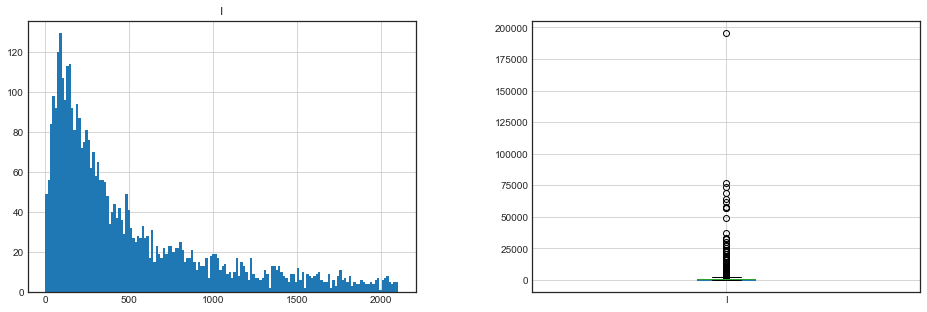

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(5)
fig.set_figwidth(16)
clienti.hist(ax=axes[0], column='I', bins=150, range=[0, 2100])
clienti.boxplot(ax=axes[1], column='I')

## Attributo Iu

In [25]:
clienti['Iu'].quantile(.90)

142.70000000000027

Dato che il 90% dei valori ottenuti è minore o uguale a 147.7, scegliamo per l'istogramma range =[0, 150] e bin=75

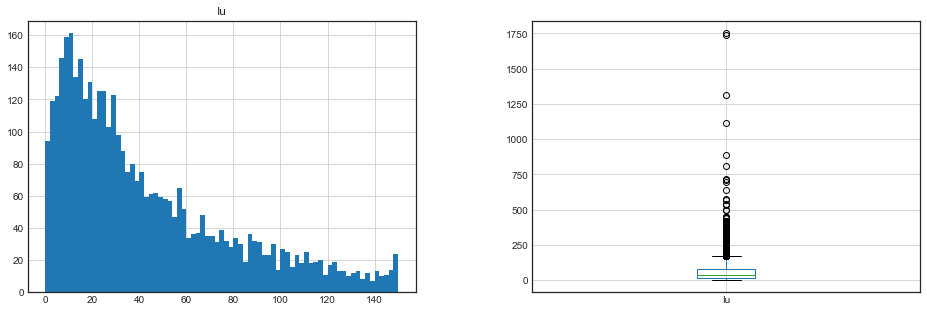

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(5)
fig.set_figwidth(16)
clienti.hist(ax=axes[0], column='Iu', bins=75, range=[0, 150])
clienti.boxplot(ax=axes[1], column='Iu')

## Attributo Imax

In [27]:
clienti['Imax'].quantile(.90)

675.7000000000003

Dato che il 90% dei valori ottenuti è minore o uguale a 675.7, scegliamo per l'istogramma range =[0, 700] e bin=100

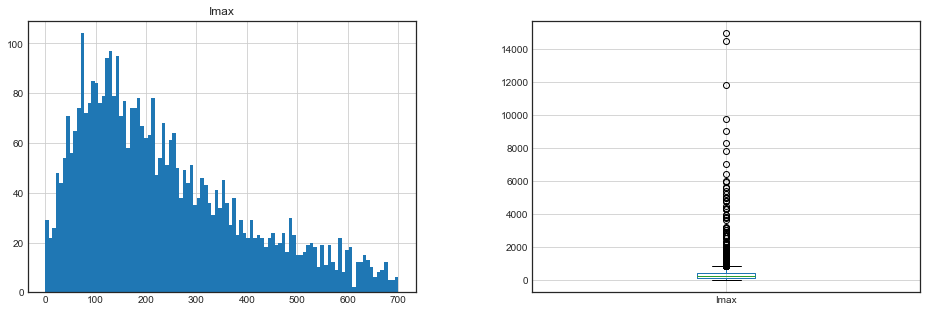

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(5)
fig.set_figwidth(16)
clienti.hist(ax=axes[0], column='Imax', bins=100, range=[0, 700])
clienti.boxplot(ax=axes[1], column='Imax')

## Attributo NumBasket

In [29]:
clienti['NumBasket'].quantile(.90)

9.0

Dato che il 90% dei valori ottenuti è minore o uguale a 9, scegliamo per l'istogramma range =[1, 9] e bin=8

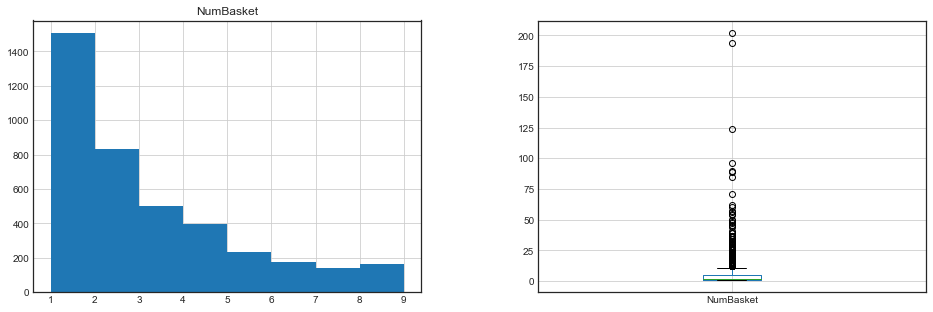

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(5)
fig.set_figwidth(16)
clienti.hist(ax=axes[0], column='NumBasket', bins=8, range=[1,9])
clienti.boxplot(ax=axes[1], column='NumBasket')

## Attributo Recency

In [31]:
clienti['Recency'].quantile(.90)

263.0

Dato che il 90% dei valori ottenuti è minore o uguale a 263, scegliamo per l'istogramma range =[0, 270] e bin=30

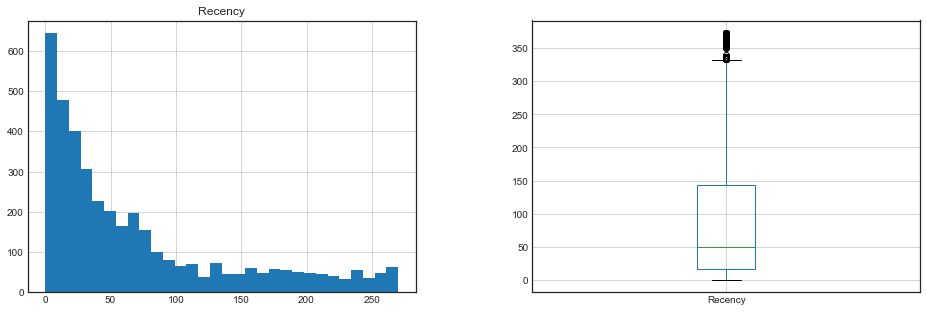

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(5)
fig.set_figwidth(16)
clienti.hist(ax=axes[0], column='Recency', bins=30, range=[0,270])
clienti.boxplot(ax=axes[1], column='Recency')

## Attributo Frequency.

In [33]:
clienti['Frequency'].quantile(.90)

200.70000000000027

Dato che il 90% dei valori ottenuti è minore o uguale a 200.7, scegliamo per l'istogramma range =[0, 210] e bin=70

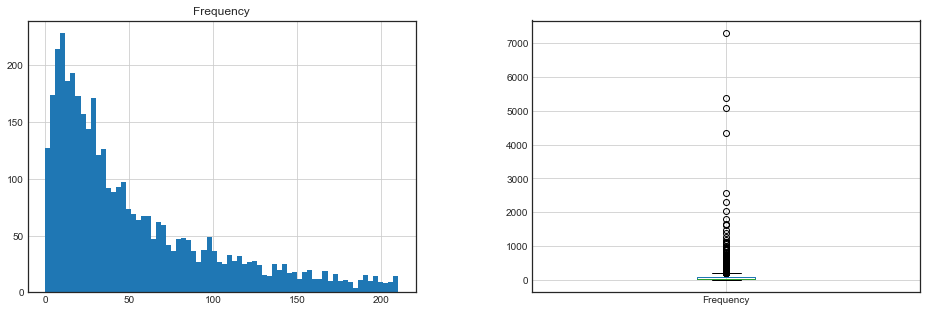

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(5)
fig.set_figwidth(16)
clienti.hist(ax=axes[0], column='Frequency', bins=70, range=[0,210])
clienti.boxplot(ax=axes[1], column='Frequency')

## Attributo MonetaryValue.

In [35]:
clienti['MonetaryValue'].quantile(.90)

3440.051000000004

Dato che il 90% dei valori ottenuti è minore o uguale a 3440.05, scegliamo per l'istogramma range =[0, 3450] e bin=150

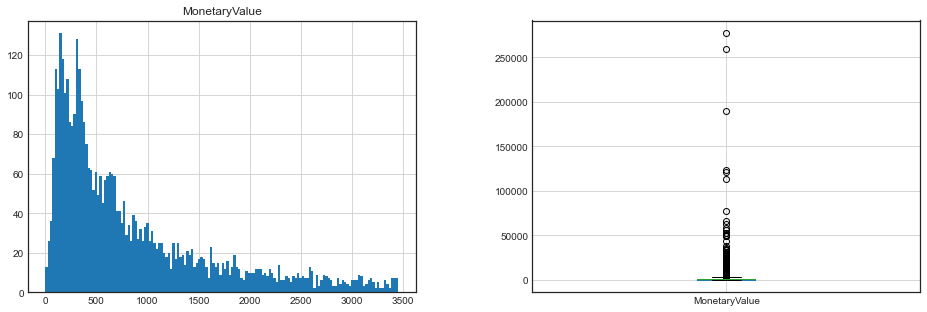

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(5)
fig.set_figwidth(16)
clienti.hist(ax=axes[0], column='MonetaryValue', bins=150, range=[0, 3450])
clienti.boxplot(ax=axes[1], column='MonetaryValue')

Si nota che gli istrogrammi degli attributi **I, Iu, Imax, NumBasket, Recency, Frequency** e **Monetary Value** hanno distribuzioni simili (uno/due picchi iniziali e poi una diminuzione drastica all'aumentare dei valori degli attributi). Inoltre, si nota dai boxplot degli attributi che ci sono diversi valori che potrebbero essere degli outliers rispetto al singolo attributo.

## Attributo EntropySpending.

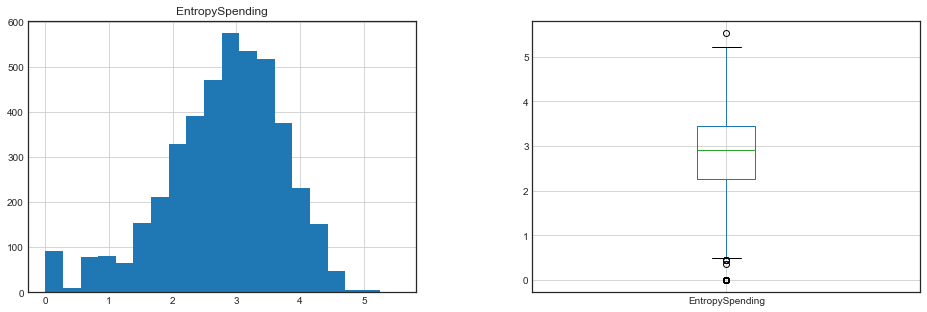

In [37]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(5)
fig.set_figwidth(16)
clienti.hist(ax=axes[0], column='EntropySpending', bins=20)
clienti.boxplot(ax=axes[1], column='EntropySpending')

## Attributo EntropyDays.

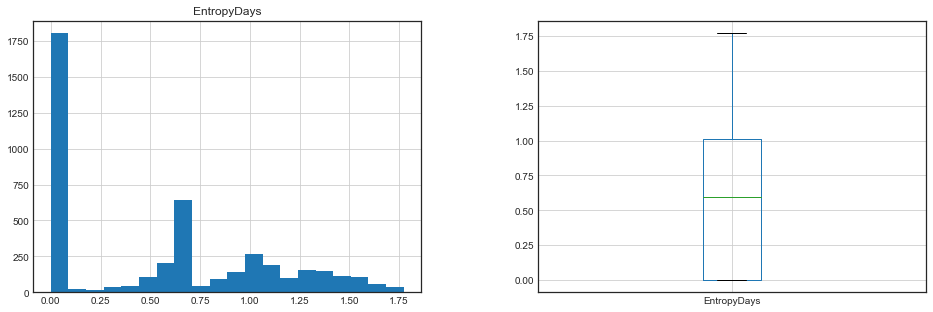

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(5)
fig.set_figwidth(16)
clienti.hist(ax=axes[0], column='EntropyDays', bins=20)
clienti.boxplot(ax=axes[1], column='EntropyDays')

## Attributo EntropyProducts.

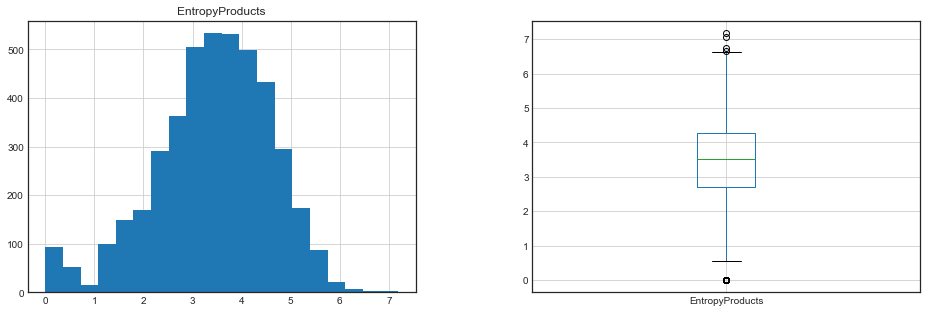

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(5)
fig.set_figwidth(16)
clienti.hist(ax=axes[0], column='EntropyProducts', bins=20)
clienti.boxplot(ax=axes[1], column='EntropyProducts')

Gli istrogrammi degli attributi **EntropySpending** e **EntropyProducts** hanno una forma simile ad una distribuzione normale. Mentre per quanto riguarda l'attributo **EntropyDays** si nota un picco iniziale in corrispondenza del primo bin dell'istogramma. Dai bloxplot si nota che gli attributi EntropySpending e EntropyProducts hanno pochi valori "outliers", mentre l'attributo EntropyDays nessuno.

## Correlazione

Controlliamo se alcune colonne sono correlate tra loro. Quindi, riduciamo la dimensione (cioè il numero di colonne) del dataframe eliminando alcune di esse.

In [40]:
clienti.corr()

,I,Iu,Imax,NumBasket,Recency,Frequency,MonetaryValue,EntropySpending,EntropyDays,EntropyProducts
I,1.000000,0.436924,0.772563,0.579933,-0.135328,0.458389,0.919603,0.238293,0.257291,0.210610
Iu,0.436924,1.000000,0.328927,0.691131,-0.301515,0.881194,0.401292,0.606284,0.448861,0.692048
Imax,0.772563,0.328927,1.000000,0.357745,-0.141372,0.281231,0.698852,0.252888,0.223264,0.228958
NumBasket,0.579933,0.691131,0.357745,1.000000,-0.262649,0.757551,0.566480,0.381922,0.515844,0.367022
Recency,-0.135328,-0.301515,-0.141372,-0.262649,1.000000,-0.209449,-0.129813,-0.419610,-0.477236,-0.403872
Frequency,0.458389,0.881194,0.281231,0.757551,-0.209449,1.000000,0.435431,0.397072,0.346264,0.455077
MonetaryValue,0.919603,0.401292,0.698852,0.566480,-0.129813,0.435431,1.000000,0.239564,0.249570,0.202970
EntropySpending,0.238293,0.606284,0.252888,0.381922,-0.419610,0.397072,0.239564,1.000000,0.532429,0.929430
EntropyDays,0.257291,0.448861,0.223264,0.515844,-0.477236,0.346264,0.249570,0.532429,1.000000,0.514594
EntropyProducts,0.210610,0.692048,0.228958,0.367022,-0.403872,0.455077,0.202970,0.929430,0.514594,1.000000


Eliminiamo gli attributi **I, Iu, NumBasket** e **EntropySpenging** in quanto hanno un'alta correlazione con i restanti attributi. Eliminiamo anche l'attributo **EntropyDays**, perché ritenuto poco significativo, poiché ci sono molti clienti che hanno fatto un solo acquisto.

In [41]:
# Eliminiamo le colonne I, Iu, NumBasket, EntropySpending e EntropyDays
clienti.drop(columns=['I','Iu', 'NumBasket', 'EntropySpending', 'EntropyDays'], inplace=True)
clienti.head(3)

,Imax,Recency,Frequency,MonetaryValue,EntropyProducts
CustomerID,,,,,
12347,676,1,182,4310.00,4.464578
12348,1248,74,27,1437.24,2.987771
12349,630,18,72,1457.55,4.276666


In seguito sono riportati gli scatter plot bidimensionali per ogni possibile coppia di attributi.

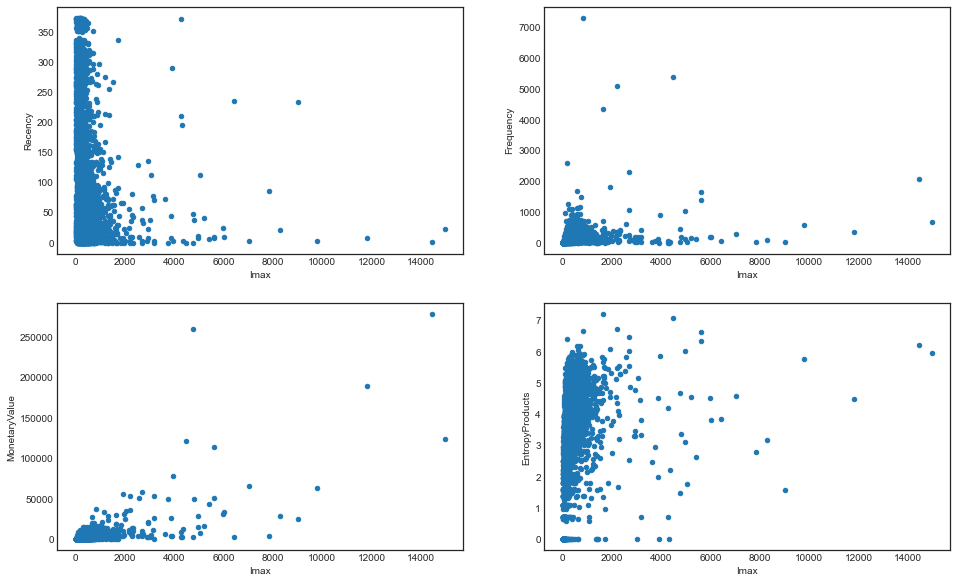

In [42]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(16)
clienti.plot.scatter(ax=axes[0,0], x='Imax', y='Recency')
clienti.plot.scatter(ax=axes[0,1], x='Imax', y='Frequency')
clienti.plot.scatter(ax=axes[1,0], x='Imax', y='MonetaryValue')
clienti.plot.scatter(ax=axes[1,1], x='Imax', y='EntropyProducts')

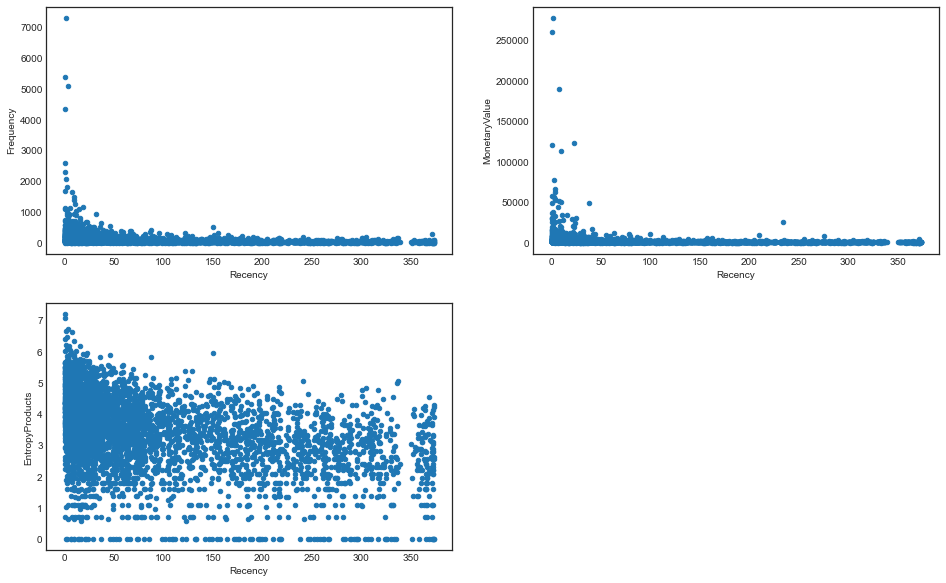

In [43]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(16)
clienti.plot.scatter(ax=axes[0,0], x='Recency', y='Frequency')
clienti.plot.scatter(ax=axes[0,1], x='Recency', y='MonetaryValue')
clienti.plot.scatter(ax=axes[1,0], x='Recency', y='EntropyProducts')
fig.delaxes(axes[1][1])

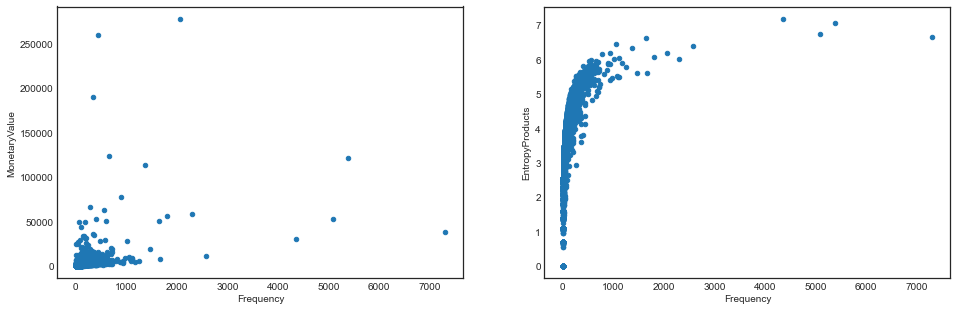

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(5)
fig.set_figwidth(16)
clienti.plot.scatter(ax=axes[0], x='Frequency', y='MonetaryValue')
clienti.plot.scatter(ax=axes[1], x='Frequency', y='EntropyProducts')

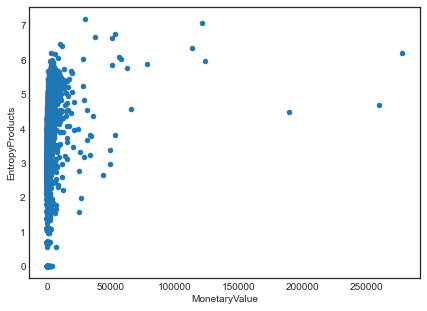

In [45]:
clienti.plot.scatter(x='MonetaryValue', y='EntropyProducts', figsize=(7,5))

Il dataframe che utilizzeremo per il clustering sarà clienti, quindi esporto il dataframe in formato csv.

In [46]:
clienti.to_csv('clienti.csv')